In [1]:
# load packages
import numpy as np 
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

In [2]:
NumBins = 6 # number of contrasts
NumHarms = 4 # number of harmonic data: 2F1, 4F1
NumConds = 4

In [3]:
cp1 = sns.color_palette("husl", 8) # color pallete 1 
cp2 = sns.color_palette("Paired", 12)  # color pallete 2
sns.set_theme() # set global plot theme
x_lev = np.arange(0,NumBins,1) # x ticks for plotting
print(x_lev)

[0 1 2 3 4 5]


In [4]:
# Main Directory of processed file from MatLab
# MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AvgCRFs\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[-2] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['AllCondCRF_AllHarmonics_pnlApp_20240315_1641.mat', 'AllCondCRF_AllHarmonics_pnlApp_20240315_1641.pkl', 'AllCondCRF_AllSess_pnlApp_20240314_1235.mat', 'AllCondCRF_AllSess_pnlApp_20240314_1235.pkl', 'AllCondCRF_AllSess_pnlApp_20240314_1237.mat', 'AllCondCRF_AllSess_pnlApp_20240314_1237.pkl', 'Clean_LTPData_20240313_1457.pkl', 'Clean_LTPData_2468F_20240316_2252.pkl', 'Clean_LTPData_2468F_20240318_2256.pkl', 'Clean_LTPData_2468F_20240319_1040.pkl', 'Clean_LTPData_firingrate_20240314_1400.pkl']
Current WD: C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\Clean_LTPData_2468F_20240319_1040.pkl
Does File #1 Exist? True


In [5]:
loadData = pkl.load(open(file_path1,'rb'))
print(loadData.keys())

pp_data = loadData['crf']  # original CRF data
diff_data =  loadData['resp_diffs'] # post - pre data for all conditions
CorrectedCRF = loadData['mod_crf']  # crf with no supersaturation=
coSubNames = loadData['coSubNames'] 
data_labels = loadData['ConditionLabels'] 
contrast_levels = loadData['ContLevs']  # for plotting x
contrast_labs  = loadData['ContLabs'] # for setting x ticks

dict_keys(['crf', 'resp_diffs', 'mod_crf', 'coSubNames', 'ConditionLabels', 'ContLevs', 'ContLabs'])


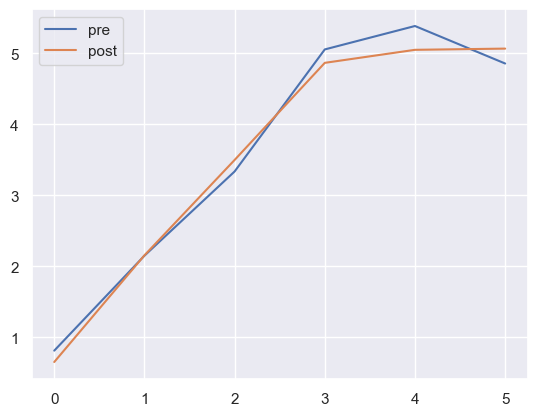

In [6]:
x = pp_data[0]

plt.plot(x[0,0:6,0], label = 'pre')
plt.plot(x[0,0:6,1], label = 'post')
plt.legend()

In [7]:
def naka_rushton(C, C50, n, Rmax, b):
    """
    This function models neural responses captured by Contrast Response Functions
     
    C50 (parameter 1) : Contrast level that yields half of max response (contrast %)
    n (parameter 2)   : Determines the curve arc for fitting (small integer)
    Rmax (Parameter 3): Max response elicited (mv)
    b (Parameter 4)   : Starting value (origin)
    """
    return ((Rmax * ((C**n) / (C50**n + C**n)))+b)

In [12]:
#def ReshapeFeedData(dIn, HarmMax = [0,1]):
dIn = x # 20 24 2 
HarmMax = [0,1] # harmonic 2f ans 4f for nr function only right now

[xiters, csweeps, cond] = dIn.shape # 20 x 24 x 2
print(dIn.shape)
NumRows = csweeps/NumBins # 4

crf_mtrx = np.zeros((xiters,int(len(HarmMax)),NumBins*2))
print(crf_mtrx.shape) # 20  2 x 

for su in range(xiters):
    pre = dIn[su,:,0] # 24
    post = dIn[su,:,1]

    pre_o = np.zeros((int(len(HarmMax)),NumBins))
    post_o = np.zeros((int(len(HarmMax)),NumBins))

    for i in range(len(HarmMax)):
        s = int(i*NumBins)
        e = int(s+NumBins)
        pre_o[i,:] = pre[s:e]
        post_o[i,:] = post[s:e]
        dOut = np.hstack((pre_o,post_o)) # 2 x 12 (harmonic x pre/post)
    crf_mtrx[su,:,:] = dOut # 20 x 2 x 12


(20, 24, 2)
(20, 2, 12)


(20, 3, 12)
(3, 12)


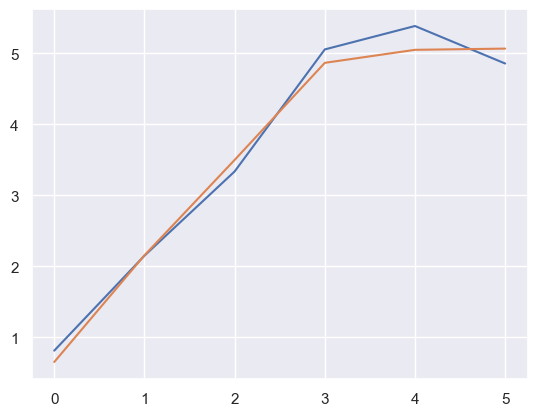

In [9]:
print(crf_mtrx.shape) # 20 x 2 x 12 [subject x [harmonic levels/]]
crf_x = crf_mtrx[0,:,:]
print(crf_x.shape) # 2 x 12
plt.plot(crf_x[0,0:6])
plt.plot(crf_x[0,6:])

In [18]:
def ReshapeFeedData(NumBins,dIn,HarmMax):
    """
    This script takes the pre x post crf for all particpants. 
    dIn = 3d array [subj x allcontrastsceepresponses x 2 ([pre = 0 , post = 1])]
    NumBins = number of contrasts used in ltp sweep condition 
    HarmMax = [x,x,x,x] = fill array to max harmonic you want to feed 
    to Naka rushon function!
    """
    xiters = dIn.shape[0] # get # of subjects 

    crf_mtrx = np.zeros((xiters,int(len(HarmMax)),NumBins*2)) # fill array to index by row 

    for su in range(xiters): # iterate for all particpants
        pre = dIn[su,:,0] # import single pre crfs per haronic 
        post = dIn[su,:,1] # import single post crfs per haronic

        pre_o = np.zeros((int(len(HarmMax)),NumBins)) # reshaped (numharmsin x numbins)
        post_o = np.zeros((int(len(HarmMax)),NumBins))

        for i in range(len(HarmMax)): # index all harmonics of interest 
            s = int(i*NumBins) # start
            e = int(s+NumBins) # end 
            pre_o[i,:] = pre[s:e] # index
            post_o[i,:] = post[s:e]
            dOut = np.hstack((pre_o,post_o)) # 2 x 12 (harmonic x pre/post) # stack sub data pre post side by side
        # save everyones data in a reshaped array 
        crf_mtrx[su,:,:] = dOut # 20 x 2 x 12

    return crf_mtrx

In [28]:
nr_dIn = {} # naka rushton data in - many abbrev from now on .. running out of names. ...

for co in range(NumConds):
    nr_dIn[co] = ReshapeFeedData(NumBins,dIn = pp_data[0], HarmMax = [0,1])
    print(nr_dIn[co].shape)


(20, 2, 12)
(20, 2, 12)
(20, 2, 12)
(20, 2, 12)


In [25]:
print(test.shape)

(20, 3, 12)
